In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import preprocessing
import csv
from statistics import mean, stdev

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.savefig('/home/jt/research/sc_vol_feats', bbox_inches='tight')
    plt.show()

In [4]:
# get target areas from file

with open('target_areas.txt') as f:
    target_areas = f.readlines()
target_areas = map(str.strip, target_areas)
print(len(target_areas))

150


In [5]:
# get aseg data from file

with open('aseg_stats.txt') as f:
    aseg_data = f.readlines()
aseg_data = map(str.split, aseg_data)
print(aseg_data[0])

['Measure:volume', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC', 'Right-vessel', 'Right-choroid-plexus', '5th-Ventricle', 'WM-hypointensities', 'Left-WM-hypointensities', 'Right-WM-hypointensities', 'non-WM-hypointensities', 'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities', 'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'Bra

In [6]:
# get indices of target areas in aseg data

feature_names = []
aseg_target_indices = []
for i in range(0, len(aseg_data[0])):
    if aseg_data[0][i] in target_areas:
        aseg_target_indices.append(i)
        feature_names.append(aseg_data[0][i])
feature_names.append('Age')
feature_names.append('Sex')

In [7]:
# make features for each patient, make patients & moca

target_aseg_data = []
patients = []
for i in aseg_data[1:]:
    patients.append(i[0])
    p = []
    for j in aseg_target_indices:
            p.append(i[j])
    target_aseg_data.append(p)

mocas = patients[:]
print(len(patients))
print(len(target_aseg_data))

303
303


In [8]:
#standarize data

target_aseg_data_s = preprocessing.scale(target_aseg_data, axis=1)
target_aseg_data_s = target_aseg_data_s.tolist()

# number of subjects, pre-removal of patients without moca diff
print(len(target_aseg_data_s))

# number of features
print(len(target_aseg_data_s[0]))

303
16


In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# get moca diffs for each patient
skipped_patients = []

age = patients[:]
sex = patients[:]

with open('Josh_finalChart.csv') as f:
    freader = csv.DictReader(f)
    for i in freader:
        
        if i['Subject'] in mocas:
            mocas[mocas.index(i['Subject'])] = i['First/Last Moca Diff']
        if i['Subject'] in age:
            age[age.index(i['Subject'])] = i['Age']
        if i['Subject'] in sex:
            sex[sex.index(i['Subject'])] = i['Sex']
        else:
            skipped_patients.append(i['Subject'])

# skipped & more_skipped removes patients without a moca diff
more_skipped = [i for i in mocas if int(i)>3000]

for i in more_skipped:
    skipped_patients.append(i)

print(len(age))
print(len(sex))

303
303


In [10]:
# remove patients with no moca diff
for i in skipped_patients:
    cur = 0
    if i in patients:
        cur = patients.index(i)
        patients.pop(cur)
        target_aseg_data.pop(cur)
        target_aseg_data_s.pop(cur)
    if i in mocas:
        mocas.remove(i)
    if i in age:    
        age.remove(i)
    if i in sex:
        sex.remove(i)
        
print(len(patients), len(mocas), len(target_aseg_data_s), len(age), len(sex))

(289, 289, 289, 289, 289)


In [11]:
# add age and sex to features
for i in range(0, len(sex)):
    if sex[i] == 'M':
        sex[i] = 0
    else:
        sex[i] = 1

sex = preprocessing.scale(sex)
age = preprocessing.scale(age)

for i in range(0,len(target_aseg_data_s)):
    target_aseg_data_s[i].append(age[i])
    target_aseg_data_s[i].append(sex[i])
    
print(len(target_aseg_data_s[0]))

18


In [12]:
mocas = [int(i) for i in mocas]
mocas = np.asarray(mocas)

patients = np.asarray(patients)
target_aseg_data = np.asarray(target_aseg_data)
target_aseg_data_s = np.asarray(target_aseg_data_s)

# remove patients who don't meet class requirements

patients = patients[np.logical_or(mocas==0, mocas<=-2)]
target_aseg_data_s = target_aseg_data_s[np.logical_or(mocas==0, mocas<=-2)]
mocas = mocas[np.logical_or(mocas==0, mocas<=-2)]

print(len(patients), len(mocas), len(target_aseg_data_s))

(164, 164, 164)


In [13]:
# create classes for mocas
# class 0: =0, class 1: <= -2

for i in range(0,len(mocas)):
    if mocas[i] == 0:
        mocas[i] = 0
    elif mocas[i] <= -2:
        mocas[i] = 1

print(mocas)
print(len(mocas), len(patients), len(target_aseg_data_s))

[1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1
 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0
 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1]
(164, 164, 164)


In [14]:
feats = []
target_aseg_data_s = np.asarray(target_aseg_data_s)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
y_allPred = []
y_allVal = []
foldNumber = 0
for train_index, val_index in skfold.split(target_aseg_data_s, mocas):

    X_foldtrain, X_foldval = target_aseg_data_s[train_index], target_aseg_data_s[val_index]
    y_foldtrain, y_foldval = mocas[train_index], mocas[val_index]

    # could use smote here, n_neighbors problem
    sm = SMOTE()
    X_train_res, y_train_res = sm.fit_sample(X_foldtrain, y_foldtrain)

    #first SVM
    clf = svm.SVC(gamma='auto', kernel='linear', decision_function_shape='ovo')
    clf.fit(X_train_res, y_train_res)
        
    y_pred = clf.predict(X_foldval)
    y_allPred = np.append(y_allPred, y_pred)
    y_allVal = np.append(y_allVal, y_foldval)
    
    print(foldNumber, accuracy_score(y_foldval, y_pred))
    foldNumber+=1

print("\nAll folds: ")
print(accuracy_score(y_allVal, y_allPred))

(0, 0.5882352941176471)
(1, 0.6363636363636364)
(2, 0.7575757575757576)
(3, 0.78125)
(4, 0.5625)

All folds: 
0.6646341463414634


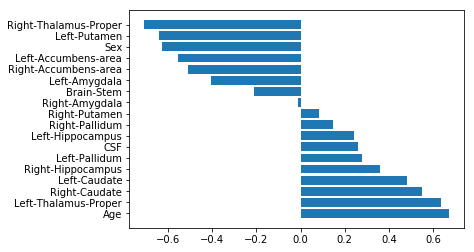

Confusion matrix, without normalization
[[37 29]
 [26 72]]


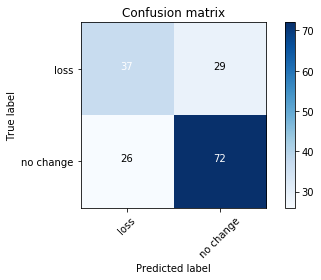

In [15]:
# run to see feature weights

f_importances(clf.coef_[0], feature_names)
plot_confusion_matrix(confusion_matrix(y_allVal, y_allPred), classes=['loss','no change'])